# Network Interpretability | proximity-quadrotor-learning

https://github.com/idsia-robotics/proximity-quadrotor-learning

## Settings

### Imports

In [0]:
# %tensorflow_version 1.x
import tensorflow as tf
# from tensorflow import keras
# when importing keras, please notice:
#   https://stackoverflow.com/a/57298275/10866825
#   https://www.pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# !pip install resnet
# import resnet as kr

import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

import math
import os
import random
import sys
from datetime import datetime
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

### Paths

In [0]:
try:
  import google.colab
  IN_COLAB = True
  from google.colab import drive
  drive.mount('/content/drive')
  models_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/trained-models/'
  new_models_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/'
  pickles_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/dataset/Whole Dataset/pickles/'
  videos_folder = '/content/video/'
  visualization_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/visualization/'
except:
  IN_COLAB = False
  # this file is into `marco-test` folder
  models_folder = '../trained-models/'
  new_models_folder = 'new-models/'
  pickles_folder = '../dataset/Whole Dataset/pickles/'
  videos_folder = 'video/'
  visualization_folder = 'visualization/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
chosen_model = 1
model_path = models_folder + 'v' + str(chosen_model) + '_model_train_size_50000_rep_1.h5'
pickle_train_path = pickles_folder + 'version' + str(chosen_model) + '/train.pickle'
pickle_test_path = pickles_folder + 'version' + str(chosen_model) + '/test.pickle'

### Utils

In [0]:
image_height = 60
image_width = 108

def compute_metrics(y_test, y_pred):
    """
        compute r2 and rmse
    Args:
        y_test: set of labels
        y_pred: set of predictions

    Returns:
        scores
    """
    rmse_score = []
    r2_score = []
    for i in range(4):
        rmse_score.append(np.math.sqrt(sk.metrics.mean_squared_error(y_test[:, i], y_pred[i])))
        r2_score.append(sk.metrics.r2_score(y_test[:, i], y_pred[i]))
    return r2_score, rmse_score

## Model Summary

In [0]:
old_model = tf.keras.models.load_model(model_path)
old_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 60, 108, 3)] 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1, 1, 256)    1235200     image_input[0][0]                
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 256)          0           model_1[1][0]                    
__________________________________________________________________________________________________
1_dense (Dense)                 (None, 256)          65792       flatten_1[0][0]                  
____________________________________________________________________________________________

In [0]:
print('RES-NET')
old_model.get_layer("model_1").summary()

RES-NET
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 108, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 54, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 54, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 30, 54, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________

## Convert dataset to video

In [0]:
test_set = pd.read_pickle(pickle_test_path).values

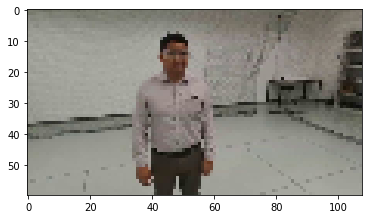

In [0]:
from IPython.display import clear_output

for i in range(5):
  clear_output(wait=True)
  plt.imshow(test_set[i, 0])
  plt.pause(0.001)

In [0]:
import cv2

images = test_set[:100, 0]
height, width, layers = images[0].shape

# initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
fps = 30
video_filename = 'output.mp4'
out = cv2.VideoWriter(videos_folder + video_filename, fourcc, fps, (width, height))

for frame in images:
  out.write(np.array(frame))
  # if IN_COLAB:
  #   google.colab.patches.cv2_imshow(frame)
  # else:
  #   cv2.imshow('video', frame)

# close out the video writer
out.release()

## Test Performance

In [0]:
test_set = pd.read_pickle(pickle_test_path).values
print('test shape: ' + str(test_set.shape))

x_test = 255 - test_set[:, 0]
x_test = np.vstack(x_test[:]).astype(np.float32)
x_test = np.reshape(x_test, (-1, image_height, image_width, 3))

y_test = test_set[:, 1]
y_test = np.vstack(y_test[:]).astype(np.float32)

visual_odom = test_set[:, 2]
visual_odom = np.vstack(visual_odom[:]).astype(np.float32)

print('x_test shape: ' + str(x_test.shape))
print('y_test shape: ' + str(y_test.shape))
print('visual_odom shape: ' + str(visual_odom.shape))

test shape: (11035, 3)
x_test shape: (11035, 60, 108, 3)
y_test shape: (11035, 4)
visual_odom shape: (11035, 2)


In [0]:
idx = range(len(x_test) // 1) # reducing dataset size
sel_x_test = x_test[idx]
sel_y_test = y_test[idx]

y_pred = np.array(old_model.predict(sel_x_test))
print('y_pred shape (variables, samples, 1): ' + str(np.shape(y_pred)))

y_pred shape (variables, samples, 1): (4, 11035, 1)


In [0]:
## only meaningful for very few samples
# print('sel_y_test: ' + str(sel_y_test))
# print('y_pred: ' + str(np.squeeze(y_pred).T))

Please note that test samples must be more than 2000 for obstaining a reliable `r2_score`.

In [0]:
r2_score, rmse_score = compute_metrics(sel_y_test, y_pred)
print('r2_score: ' + str(r2_score))
print('rmse_score: ' + str(rmse_score))

r2_score: [0.8323426858756517, 0.8651102246898569, 0.8288967670812277, 0.7989459419395898]
rmse_score: [0.10800385614499043, 0.1035196510467694, 0.05054580917664484, 0.25578245797684734]


## Ground truth & predictions distribution

GROUND TRUTH
shape (11035, 4)
avg & median test_x:  1.4500763 	 1.4420592
avg & median test_y:  0.04780924 	 0.06810694
avg & median test_z:  -0.002073689 	 0.0018481016
avg & median test_w:  0.102836646 	 0.14611927


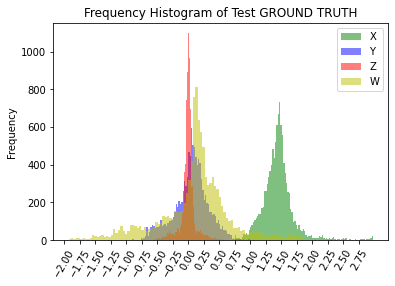

In [0]:
print('GROUND TRUTH')
print('shape', sel_y_test.shape)
print('avg & median test_x: ', np.average(sel_y_test[:,0]), '\t', np.median(sel_y_test[:,0]))
print('avg & median test_y: ', np.average(sel_y_test[:,1]), '\t', np.median(sel_y_test[:,1]))
print('avg & median test_z: ', np.average(sel_y_test[:,2]), '\t', np.median(sel_y_test[:,2]))
print('avg & median test_w: ', np.average(sel_y_test[:,3]), '\t', np.median(sel_y_test[:,3]))

kwargs = dict(alpha=0.5, bins=100)
plt.hist(sel_y_test[:,0], **kwargs, color='g', label='X')
plt.hist(sel_y_test[:,1], **kwargs, color='b', label='Y')
plt.hist(sel_y_test[:,2], **kwargs, color='r', label='Z')
plt.hist(sel_y_test[:,3], **kwargs, color='y', label='W')
plt.gca().set(title='Frequency Histogram of Test GROUND TRUTH', ylabel='Frequency')
plt.xticks(np.arange(-2, 3, 0.25), rotation=60)
plt.legend();

PREDICTIONS
shape (11035, 4)
avg & median pred_x:  1.4092039 	 1.4092526
avg & median pred_y:  0.045730766 	 0.06735058
avg & median pred_z:  -0.008128054 	 -0.0008884399
avg & median pred_w:  0.034671996 	 0.072400846


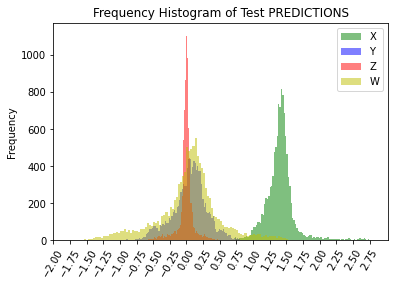

In [0]:
predictions = np.squeeze(y_pred).T

print('PREDICTIONS')
print('shape', predictions.shape)
print('avg & median pred_x: ', np.average(predictions[:,0]), '\t', np.median(predictions[:,0]))
print('avg & median pred_y: ', np.average(predictions[:,1]), '\t', np.median(predictions[:,1]))
print('avg & median pred_z: ', np.average(predictions[:,2]), '\t', np.median(predictions[:,2]))
print('avg & median pred_w: ', np.average(predictions[:,3]), '\t', np.median(predictions[:,3]))

kwargs = dict(alpha=0.5, bins=100)
plt.hist(predictions[:,0], **kwargs, color='g', label='X')
plt.hist(predictions[:,1], **kwargs, color='b', label='Y')
plt.hist(predictions[:,2], **kwargs, color='r', label='Z')
plt.hist(predictions[:,3], **kwargs, color='y', label='W')
plt.gca().set(title='Frequency Histogram of Test PREDICTIONS', ylabel='Frequency')
plt.xticks(np.arange(-2, 3, 0.25), rotation=60)
plt.legend();

## Regression to Classification

### Dataset modification

Here, **regression variables** in the ground truth are used to retrieve **classification variables** (added to the dataset `y`) by discretizing continous values accordingly to arbitrary defined bin intervals.

In [0]:
train_set = pd.read_pickle(pickle_train_path).values
train_set = train_set[:20000] # reducing dataset size
print('train shape: ' + str(train_set.shape))

train shape: (20000, 3)


In [0]:
x_train = 255 - train_set[:, 0]
x_train = np.vstack(x_train[:]).astype(np.float32)
x_train = np.reshape(x_train, (-1, image_height, image_width, 3))

y_train = train_set[:, 1]
y_train = np.vstack(y_train[:]).astype(np.float32)

visual_odom = train_set[:, 2]
visual_odom = np.vstack(visual_odom[:]).astype(np.float32)

print('x_train shape: ' + str(x_train.shape))
print('y_train shape: ' + str(y_train.shape))
print('visual_odom shape: ' + str(visual_odom.shape))

x_train shape: (20000, 60, 108, 3)
y_train shape: (20000, 4)
visual_odom shape: (20000, 2)


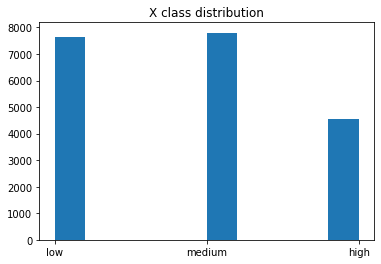

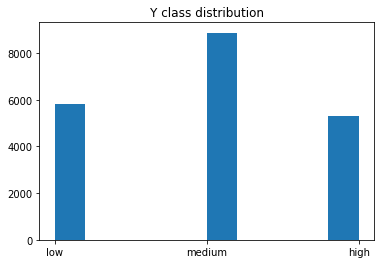

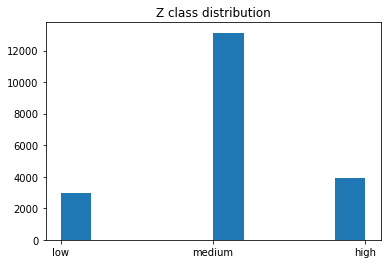

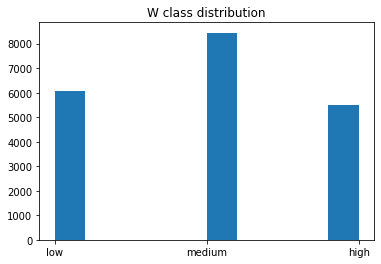

In [0]:
var_labels = ['low','medium','high']


# ---- X

var_x_values = y_train[:,0]
var_x_bins = np.array([-np.inf, 1.4, 1.6, np.inf])
var_x_assign = np.digitize(var_x_values, var_x_bins) - 1
plt.hist(var_x_assign)
plt.xticks(range(3), var_labels)
plt.title('X class distribution')
plt.show()

# ---- Y

plt.clf()
var_y_values = y_train[:,1]
var_y_bins = np.array([-np.inf, -0.15, 0.15, np.inf])
var_y_assign = np.digitize(var_y_values, var_y_bins) - 1
plt.hist(var_y_assign)
plt.xticks(range(3), var_labels)
plt.title('Y class distribution')
plt.show()

# ---- Z

var_z_values = y_train[:,2]
var_z_bins = np.array([-np.inf, -0.05, 0.05, np.inf])
var_z_assign = np.digitize(var_z_values, var_z_bins) - 1
plt.hist(var_z_assign)
plt.xticks(range(3), var_labels)
plt.title('Z class distribution')
plt.show()

# ---- W

var_w_values = y_train[:,3]
var_w_bins = np.array([-np.inf, -0.2, 0.2, np.inf])
var_w_assign = np.digitize(var_w_values, var_w_bins) - 1
plt.hist(var_w_assign)
plt.xticks(range(3), var_labels)
plt.title('W class distribution')
plt.show()


# # ---- Values renaming

# var_x_assign = [var_labels[i] for i in var_x_assign]
# var_y_assign = [var_labels[i] for i in var_y_assign]
# var_z_assign = [var_labels[i] for i in var_z_assign]
# var_w_assign = [var_labels[i] for i in var_w_assign]


# ---- Train set Y modification
stack = np.squeeze(np.dstack((var_x_assign, var_y_assign, var_z_assign, var_w_assign)))
y_train = np.append(y_train, stack, axis=1)

In [0]:
print('x_train shape', x_train.shape)
print('y_train shape', y_train.shape)
print()

n_val = x_train.shape[0] // 4

ix_val, ix_tr = np.split(np.random.permutation(x_train.shape[0]), [n_val])
x_valid_feed = x_train[ix_val, :]
x_train_feed = x_train[ix_tr, :]
y_valid_tmp = y_train[ix_val, :]
y_train_tmp = y_train[ix_tr, :]

print('x_valid_feed shape', x_valid_feed.shape)
print('x_train_feed shape', x_train_feed.shape)
print('y_valid_tmp shape', y_valid_tmp.shape)
print('y_train_tmp shape', y_train_tmp.shape)

x_train shape (20000, 60, 108, 3)
y_train shape (20000, 8)

x_valid_feed shape (5000, 60, 108, 3)
x_train_feed shape (15000, 60, 108, 3)
y_valid_tmp shape (5000, 8)
y_train_tmp shape (15000, 8)


In [0]:
# regression variables
yvr = np.transpose(np.copy(y_valid_tmp[:,0:4]))
ytr = np.transpose(np.copy(y_train_tmp[:,0:4]))
print('regression variables \t\t', np.shape(yvr))
print('regression variables \t\t', np.shape(ytr))

# classification variables
cat_val = to_categorical(np.copy(y_valid_tmp[:,4:8]))
cat_train = to_categorical(np.copy(y_train_tmp[:,4:8]))
yvc = np.transpose(cat_val, (1, 0, 2))
ytc = np.transpose(cat_train, (1, 0, 2))
print('classification variables \t', np.shape(yvc))
print('classification variables \t', np.shape(ytc))

y_valid_feed = [yvr[0], yvr[1], yvr[2], yvr[3], yvc[0], yvc[1], yvc[2], yvc[3]]
y_train_feed = [ytr[0], ytr[1], ytr[2], ytr[3], ytc[0], ytc[1], ytc[2], ytc[3]]
print('\nNote that np.shape(y_train_feed) cannot be computed because elements have different shapes:') 
print('total valid variables \t\t', len(y_valid_feed))
print('single valid regression var \t', np.shape(y_valid_feed[0]))
print('single valid multi-class var \t', np.shape(y_valid_feed[4]))
print('total train variables \t\t', len(y_train_feed))
print('single train regression var \t', np.shape(y_train_feed[0]))
print('single train multi-class var \t', np.shape(y_train_feed[4]))

regression variables 		 (4, 5000)
regression variables 		 (4, 15000)
classification variables 	 (4, 5000, 3)
classification variables 	 (4, 15000, 3)

Note that np.shape(y_train_feed) cannot be computed because elements have different shapes:
total valid variables 		 8
single valid regression var 	 (5000,)
single valid multi-class var 	 (5000, 3)
total train variables 		 8
single train regression var 	 (15000,)
single train multi-class var 	 (15000, 3)


### Model modification

Following code is inspired by these links: 

[Transfer Learning Official Tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=it)  
[GituHub discussion about CNN modification after loading](https://github.com/keras-team/keras/issues/8772)  
[Weights reloading](https://stackoverflow.com/questions/43714713/modify-keras-model-after-training) (automatically done by using previous link)  
[Classification an regression using the same NN](https://stackoverflow.com/questions/54847320/classification-and-regression-using-the-same-neural-network-using-keras)  
[Classification ground truth as categorical](https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/)  


In [0]:
old_model = tf.keras.models.load_model(model_path)
old_model.trainable = False # all previous layers are now non-trainable

y_1, y_2, y_3, y_4 = [old_model.layers[i].output for i in np.arange(-4, 0)] # old regression variables

last_dense = old_model.get_layer('2_dense').output # used to attach new classification variables
y_5 = (Dense(3, activation='softmax', name='x_class'))(last_dense)
y_6 = (Dense(3, activation='softmax', name='y_class'))(last_dense)
y_7 = (Dense(3, activation='softmax', name='z_class'))(last_dense)
y_8 = (Dense(3, activation='softmax', name='yaw_class'))(last_dense)

new_model = Model(inputs=old_model.inputs, outputs=[y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8])

# # check weights equality (the two prints should output the same values)
# print('2_dense old weights', old_model.get_layer('2_dense').get_weights())
# print('2_dense new weights', new_model.get_layer('2_dense').get_weights())

new_model.summary()
print('Please notice that only the new classification layers are now trainable.')

losses = list(np.array([['mean_absolute_error'] * 4, ['categorical_crossentropy'] * 4]).flatten())

new_model.compile(loss=losses,
              metrics=['mse', 'accuracy'],
              optimizer='adam')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 60, 108, 3)] 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1, 1, 256)    1235200     image_input[0][0]                
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 256)          0           model_1[1][0]                    
__________________________________________________________________________________________________
1_dense (Dense)                 (None, 256)          65792       flatten_1[0][0]                  
______________________________________________________________________________________________

## Model training

In [0]:
callbacks = []

history = new_model.fit(
    x = x_train_feed, 
    y = y_train_feed,
    # validation_split = 0.30,
    validation_data = (x_valid_feed, y_valid_feed),
    batch_size = 64,
    epochs = 10, 
    callbacks = callbacks, 
    verbose = 1)

Epoch 1/10
235/235 [==============================] - 5s 22ms/step - loss: 3.7164 - x_pred_loss: 0.0111 - y_pred_loss: 0.0122 - z_pred_loss: 0.0077 - yaw_pred_loss: 0.0191 - x_class_loss: 1.0260 - y_class_loss: 0.9096 - z_class_loss: 0.8720 - yaw_class_loss: 0.8302 - x_pred_mse: 3.0483e-04 - x_pred_accuracy: 0.0000e+00 - y_pred_mse: 4.7262e-04 - y_pred_accuracy: 0.0000e+00 - z_pred_mse: 2.2229e-04 - z_pred_accuracy: 0.0000e+00 - yaw_pred_mse: 0.0010 - yaw_pred_accuracy: 0.0000e+00 - x_class_mse: 0.2062 - x_class_accuracy: 0.4808 - y_class_mse: 0.1807 - y_class_accuracy: 0.5973 - z_class_mse: 0.1712 - z_class_accuracy: 0.6521 - yaw_class_mse: 0.1627 - yaw_class_accuracy: 0.6921 - val_loss: 3.3152 - val_x_pred_loss: 0.0114 - val_y_pred_loss: 0.0123 - val_z_pred_loss: 0.0080 - val_yaw_pred_loss: 0.0203 - val_x_class_loss: 0.9817 - val_y_class_loss: 0.7638 - val_z_class_loss: 0.7936 - val_yaw_class_loss: 0.6955 - val_x_pred_mse: 3.6502e-04 - val_x_pred_accuracy: 0.0000e+00 - val_y_pred_mse

##### **Tf-explain**: not working with multi-output models (collapse this)

In [0]:
# # !pip install tf_explain
# from tf_explain.core.grad_cam import GradCAM
# from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
# from tf_explain.core.smoothgrad import SmoothGrad
# from tf_explain.core.activations import ExtractActivations
# from tf_explain.core.vanilla_gradients import VanillaGradients
# import time

# timestr = time.strftime("%Y%m%d_%H%M%S")
# random_indices = np.random.randint(0, x_valid_feed.shape[0], size = 4)
# variables = ['X', 'Y', 'Z', 'YAW']

# var_i = 3
# var_name = variables[var_i]
# # only works with single-output model, so the model has to be properly modified

# # for var_i, var_name in enumerate(variables): # looping on model variables
# for class_index in range(y_valid_feed[4].shape[1]): # lopping on output classes
#   explainer = OcclusionSensitivity()
#   output = explainer.explain(
#       validation_data = (x_valid_feed[random_indices], y_valid_feed[4 + var_i][random_indices]),
#       model = loaded_model,
#       class_index = class_index,
#       patch_size = 4)
#   filename = timestr + '_' + explainer.__class__.__name__ + '_var'+ var_name +'_class' + str(class_index) + '.jpg'
#   explainer.save(output, visualization_folder + 'EXPLAIN', filename)

##### different training (collapse this)

In [0]:
# def data_augmentor(sample, target, model_type):
#     """
#         recieves frame and targets with p=50% flip vertically
#     Args:
#         target:  target for CNN
#         model_type:
#         sample:
#     Returns:
#         datapoints and targets eventually flipped

#     """
#     print(target[1])
#     if model_type == 1:
#         frame = sample
#         if np.random.choice([True, False]):
#             frame = np.fliplr(frame)  # IMG
#             target[1] = -target[1]  # Y
#             target[3] = -target[3]  # Relative YAW
#         return frame, target
#     # elif model_type == 2:
#     #     frame = sample[0]
#     #     vel = sample[1]
#     #     x_2 = np.asarray([vel[0], vel[1]])
#     #     if np.random.choice([True, False]):
#     #         frame = np.fliplr(frame)  # IMG
#     #         target[1] = -target[1]  # y_lin
#     #         target[3] = -target[3]  # z_ang
#     #         x_2 = np.asarray([vel[0], -vel[1]])
#     #     return frame, x_2, target
#     # elif model_type == 3:
#     #     rel_pose = sample[0]
#     #     vel = sample[1]
#     #     x_2 = np.asarray([vel[0], vel[1]])
#     #     if np.random.choice([True, False]):
#     #         rel_pose[1] = -rel_pose[1]
#     #         rel_pose[3] = -rel_pose[3]
#     #         target[1] = -target[1]  # y_lin
#     #         target[3] = -target[3]  # z_ang
#     #         x_2 = np.asarray([vel[0], -vel[1]])
#     #     return rel_pose, x_2, target
#     else:
#         print("ERROR: Model flag in data augmentor is not correct: " + str(model_type))
#         sys.exit(1)


# def generator(samples, targets, batch_size, model_type):
#     """
#         Genereator of minibatches of size batch_size
#     Args:
#         samples: sample array
#         targets: targets array
#         batch_size: batch size
#         model_type: type of architecture created
#     Yields:
#         batch of samples and array of batch of targets
#     """

#     if model_type == 1:
#         while True:
#             indexes = np.random.choice(np.arange(0, samples.shape[0]), batch_size)
#             batch_samples = samples[indexes]
#             batch_targets = targets[indexes]
#             for i in range(0, batch_samples.shape[0]):
#                 batch_samples[i], batch_targets[i] = data_augmentor(batch_samples[i], batch_targets[i], model_type)
#             yield batch_samples, [batch_targets[:, 0], batch_targets[:, 1], batch_targets[:, 2], batch_targets[:, 3]]
#     # elif model_type == 2:
#     #     while True:
#     #         samples_1 = samples[0]
#     #         samples_2 = samples[1]
#     #         indexes = np.random.choice(np.arange(0, samples_1.shape[0]), batch_size)
#     #         batch_samples_1 = samples_1[indexes]
#     #         batch_samples_2 = samples_2[indexes]
#     #         batch_targets = targets[indexes]
#     #         for i in range(0, batch_samples_1.shape[0]):
#     #             batch_samples_1[i], batch_samples_2[i], batch_targets[i] = data_augmentor([batch_samples_1[i], batch_samples_2[i]], batch_targets[i], model_type)
#     #         yield [batch_samples_1, np.asarray(batch_samples_2)], [batch_targets[:, 0], batch_targets[:, 1], batch_targets[:, 2], batch_targets[:, 3]]
#     # elif model_type == 3:
#     #     while True:
#     #         samples_1 = samples[0]
#     #         samples_2 = samples[1]
#     #         indexes = np.random.choice(np.arange(0, samples_1.shape[0]), batch_size)
#     #         batch_samples_1 = samples_1[indexes]
#     #         batch_samples_2 = samples_2[indexes]
#     #         batch_targets = targets[indexes]
#     #         for i in range(0, batch_samples_1.shape[0]):
#     #             batch_samples_1[i], batch_samples_2[i], batch_targets[i] = data_augmentor([batch_samples_1[i], batch_samples_2[i]], batch_targets[i], model_type)
#     #         yield [batch_samples_1, np.asarray(batch_samples_2)], [batch_targets[:, 0], batch_targets[:, 1], batch_targets[:, 2], batch_targets[:, 3]]
#     else:
#         print("ERROR: Model flag in generator is not correct: " + str(model_type))
#         sys.exit(1)

In [0]:
# batch_size = 64
# epochs = 2

# batch_per_epoch = math.ceil(x_train.shape[0] / batch_size)
# gen = generator(x_train, y_train, batch_size, model_type=chosen_model)

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.1e-6)
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1)

In [0]:
# history = new_model.fit_generator(generator=gen,
#                               epochs=epochs,
#                               steps_per_epoch=batch_per_epoch,
#                               callbacks=[lr_reducer, early_stop],
#                               verbose=2)

### Performances

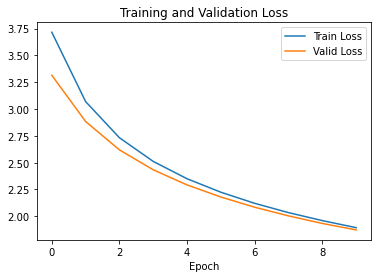

In [0]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

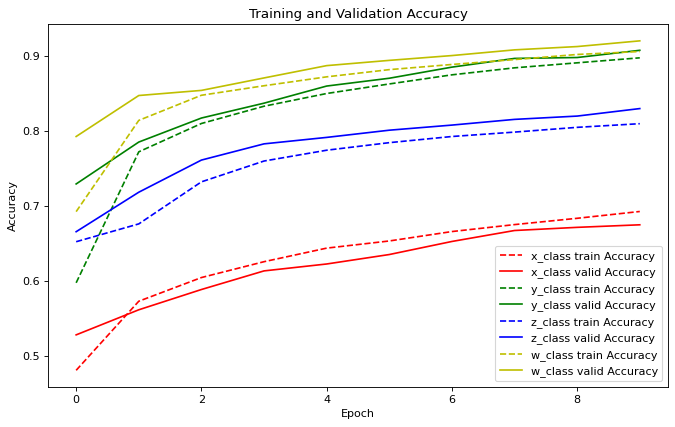

In [0]:
plt.figure(num=None, figsize=(10, 6), dpi=80)
plt.plot(history.history['x_class_accuracy'], 'r--', label='x_class train Accuracy')
plt.plot(history.history['val_x_class_accuracy'], 'r', label='x_class valid Accuracy')
plt.plot(history.history['y_class_accuracy'], 'g--', label='y_class train Accuracy')
plt.plot(history.history['val_y_class_accuracy'], 'g', label='y_class valid Accuracy')
plt.plot(history.history['z_class_accuracy'], 'b--', label='z_class train Accuracy')
plt.plot(history.history['val_z_class_accuracy'], 'b', label='z_class valid Accuracy')
plt.plot(history.history['yaw_class_accuracy'], 'y--', label='w_class train Accuracy')
plt.plot(history.history['val_yaw_class_accuracy'], 'y', label='w_class valid Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')
plt.show()

## Demo

input shape (None, 60, 108, 3)
batch shape (1, 60, 108, 3)

actual regr [ 1.50635362  0.01027246  0.00467765 -0.6327408 ]
actual class [1. 1. 1. 0.]
actual class ['medium', 'medium', 'medium', 'low']

pred regr [ 1.5157946  -0.00163712  0.00537838 -0.6309285 ]
pred class [1 1 1 0]
pred class ['medium', 'medium', 'medium', 'low']

class prediction softmax


[array([[0.2722217, 0.507667 , 0.2201113]], dtype=float32),
 array([[0.24390164, 0.6811164 , 0.07498194]], dtype=float32),
 array([[0.08099908, 0.77524024, 0.14376065]], dtype=float32),
 array([[0.93664986, 0.06227612, 0.00107404]], dtype=float32)]

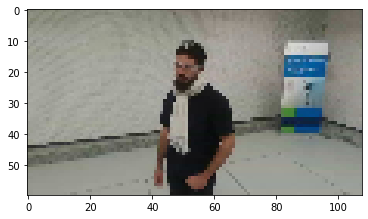

In [0]:
frame_idx = np.random.randint(0, x_train.shape[0])
batch = np.array([x_train[frame_idx]]) # input image

print('input shape', new_model.input_shape)
print('batch shape', batch.shape)

plt.imshow(train_set[frame_idx,0])

print()
print('actual regr', y_train[frame_idx,0:4])
print('actual class', y_train[frame_idx,4:8])
print('actual class', [var_labels[int(i)] for i in y_train[frame_idx,4:8]])

prediction = new_model.predict(batch) # model prediction

prediction_regr = np.array(prediction[0:4]).flatten()
prediction_class_argmax = np.argmax(prediction[4:8], axis=2).flatten()

print()
print('pred regr', prediction_regr)
print('pred class', prediction_class_argmax)
print('pred class', [var_labels[int(i)] for i in prediction_class_argmax])

print()
print('class prediction softmax')
prediction[4:8]

In [0]:
variable_names = ['x', 'y', 'z', 'yaw']
variable_idx = 0
class_idxs_sorted = np.argsort(prediction[4 + variable_idx].flatten())[::-1]

print('Predictions for variable', variable_names[variable_idx])
for i, idx in enumerate(class_idxs_sorted[:3]):
    print("Top {} predicted class:     Pr(Class={:6} [index={}]) = {:5.3f}".format(
          i + 1,var_labels[idx],idx,prediction[4 + variable_idx][0, idx]))

Predictions for variable x
Top 1 predicted class:     Pr(Class=medium [index=1]) = 0.508
Top 2 predicted class:     Pr(Class=low    [index=0]) = 0.272
Top 3 predicted class:     Pr(Class=high   [index=2]) = 0.220


## Model saving

In [0]:
import time
timestr = time.strftime("%Y%m%d_%H%M%S")

new_model_namepath = new_models_folder + 'v' + str(chosen_model) + '_newmodel_' + timestr + '_(classification only)'

# plot_model(new_model, to_file = new_model_namepath + '.png', show_shapes = True, expand_nested = False)
# new_model.save(new_model_namepath + '.h5')

## Network Visualization

Using `tf-explain` gives [this issue](https://github.com/sicara/tf-explain/issues/116).

So, we try [keras-vis](https://github.com/raghakot/keras-vis) with [this tutorial](https://fairyonice.github.io/Grad-CAM-with-keras-vis.html), but `keras-vis` directly uses `keras` instead of `tensorflow-keras`, then it is not compatible with our model and we get [this error](https://stackoverflow.com/questions/58878421/unexpected-keyword-argument-ragged-in-keras?answertab=active#tab-top) if trying to use it.  

We insted rely on [tf-keras-vis](https://github.com/keisen/tf-keras-vis) as suggested [here](https://github.com/raghakot/keras-vis/issues/160#issuecomment-567930344), following [this GradCAM tutorial](https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb).

### Model

In [0]:
new_model_namepath = new_models_folder + 'v1_newmodel_20200506_165916'
saved_model = tf.keras.models.load_model(new_model_namepath + '.h5')

print('SAVED MODEL')
saved_model.summary()

print('\n\nINTERNAL RESNET')
saved_model.get_layer('model_1').summary()

SAVED MODEL
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 60, 108, 3)] 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1, 1, 256)    1235200     image_input[0][0]                
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 256)          0           model_1[1][0]                    
__________________________________________________________________________________________________
1_dense (Dense)                 (None, 256)          65792       flatten_1[0][0]                  
__________________________________________________________________________________

##### Not working `keras-vis` (collpase this)

In [0]:
# # !pip install git+https://github.com/raghakot/keras-vis.git
# from vis.utils import utils
# from vis.visualization import visualize_cam

# def plot_map(grads):
#     fig, axes = plt.subplots(1,2,figsize=(14,5))
#     axes[0].imshow(_img)
#     axes[1].imshow(_img)
#     i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
#     fig.colorbar(i)
#     plt.suptitle("Pr(class={}) = {:5.2f}".format(
#                       classlabel[class_idx],
#                       y_pred[0,class_idx]))

# # Utility to search for layer index by name. 
# layer_idx = utils.find_layer_idx(saved_model, 'x_class')

# # Swap softmax with linear
# saved_model.layers[layer_idx].activation = tf.keras.activations.linear
# model2 = utils.apply_modifications(saved_model, custom_objects={"keras": tf.keras})

# penultimate_layer_idx = utils.find_layer_idx(saved_model, "block5_conv3") 
# class_idx  = 0
# seed_input = np.array([x_train[np.random.randint(0, x_train.shape[0])]])
# grad_top1  = visualize_cam(saved_model, layer_idx, class_idx, seed_input, 
#                            penultimate_layer_idx = penultimate_layer_idx,#None,
#                            backprop_modifier     = None,
#                            grad_modifier         = None)

# plot_map(grad_top1)

### Data selection

In [0]:
!pip install tf-keras-vis
from tf_keras_vis.utils import print_gpus
print_gpus()

1 Physical GPUs, 1 Logical GPU


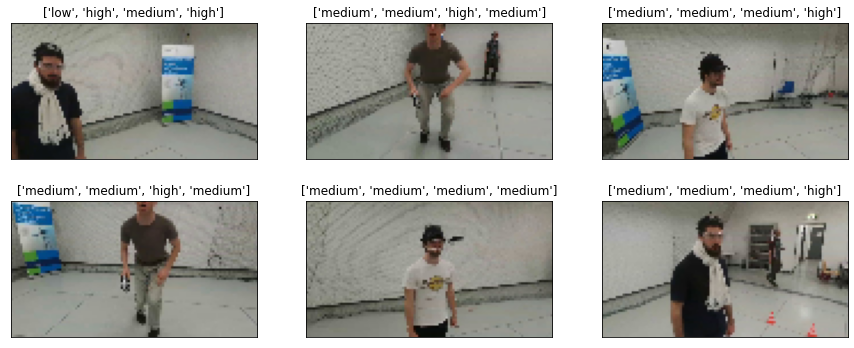

In [0]:
images_number = 6
ncols = 3
nrows = np.math.ceil(images_number/ncols)
max_random = x_train.shape[0]

def get_subplots():
  return plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3), subplot_kw={'xticks': [], 'yticks': []})


vis_idx = np.random.randint(0, max_random, images_number)
vis_img = np.array(train_set[vis_idx, 0].tolist()) # images
vis_x = np.array(x_train[vis_idx].tolist()) # model inputs

vis_prediction = saved_model.predict(vis_x) # model prediction
img_class_pred = np.argmax(vis_prediction[4:8], axis=2).T # rows=images, cols=variables

# images visualization
f, ax = get_subplots()
for i in range(images_number):
  if(nrows == 1):
    ax[i].set_title([var_labels[int(j)] for j in img_class_pred[i]])
    ax[i].imshow(vis_img[i])
  else:
    ax[i//ncols, i%ncols].set_title([var_labels[int(j)] for j in img_class_pred[i]])
    ax[i//ncols, i%ncols].imshow(vis_img[i])

### Common params

In [0]:
# Define modifier to replace a softmax function of the given layer to a linear function.
def model_modifier(m):
  m.get_layer('x_class').activation = tf.keras.activations.linear
  m.get_layer('y_class').activation = tf.keras.activations.linear
  m.get_layer('z_class').activation = tf.keras.activations.linear
  m.get_layer('yaw_class').activation = tf.keras.activations.linear

### Vanilla Saliency

Saliency generate the saliency map that appears input regions that a change in the input value contribute the output value.

> Note: The softmax activation function which is applied to model's last layer may obstruct generating shape attention images, so that you need to replace the function to a linear function using model_modifier.



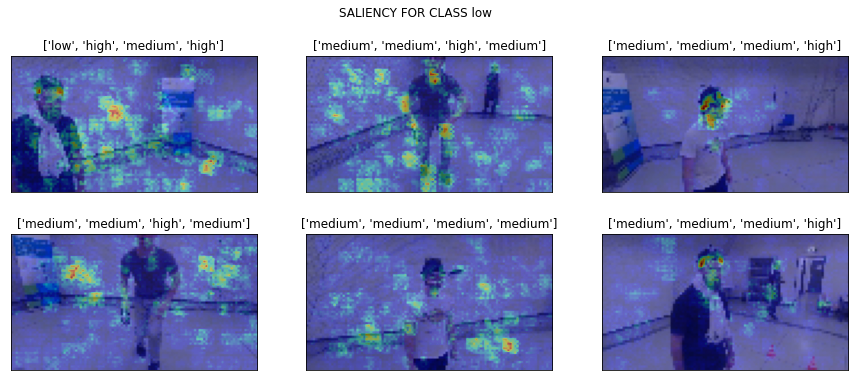

In [0]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

# Create Saliency object
saliency = Saliency(saved_model, model_modifier)

# Define loss function. 
class_label = 'low'
loss = lambda output: K.mean(output[:,var_labels.index(class_label)]) if output.shape[1] == 3 else K.mean(output[10:20])

# Generate saliency map
saliency_map = saliency(loss, vis_x)
saliency_map = normalize(saliency_map)

f, ax = get_subplots()
f.suptitle('SALIENCY FOR CLASS ' + class_label)
for i in range(len(saliency_map)):
  if(nrows == 1):
    ax[i].set_title([var_labels[int(j)] for j in img_class_pred[i]])
    ax[i].imshow(vis_img[i])
    ax[i].imshow(saliency_map[i], cmap='jet', alpha=0.4)
  else:
    ax[i//ncols, i%ncols].set_title([var_labels[int(j)] for j in img_class_pred[i]])
    ax[i//ncols, i%ncols].imshow(vis_img[i])
    ax[i//ncols, i%ncols].imshow(saliency_map[i], cmap='jet', alpha=0.4)

### SmoothGrad

As you can see avobe, Vanilla Saliency map is too noisy, so that let's remove noise in saliency map using SmoothGrad! SmoothGrad is a algorism that reduce noise including saliency map by adding noise to input image.

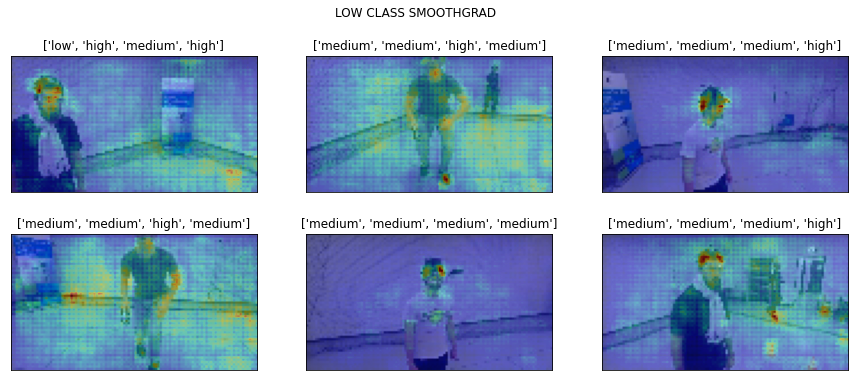

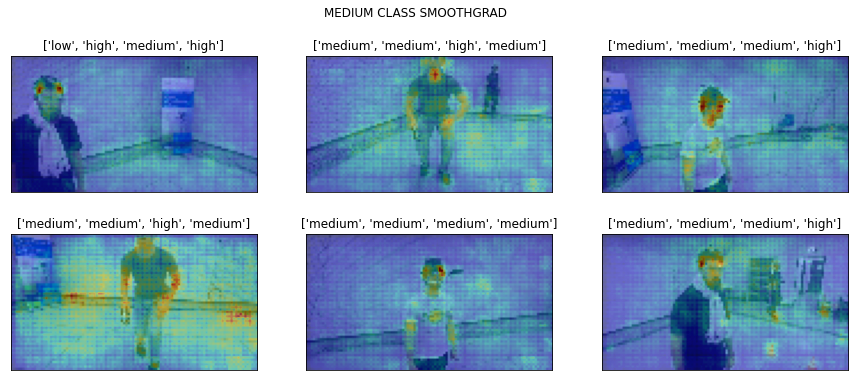

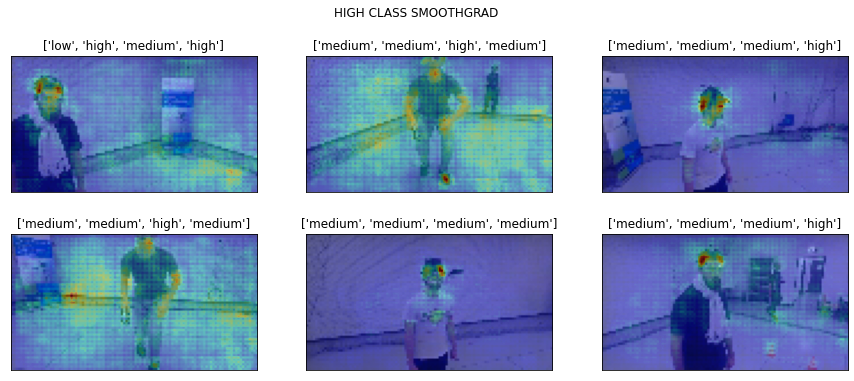

In [0]:
loss_low = lambda output: K.mean(output[:,var_labels.index('low')]) if output.shape[1] == 3 else K.mean(output)
loss_medium = lambda output: K.mean(output[:,var_labels.index('medium')]) if output.shape[1] == 3 else K.mean(output)
loss_high = lambda output: K.mean(output[:,var_labels.index('high')]) if output.shape[1] == 3 else K.mean(output)

# Generate saliency map with smoothing that reduce noise by adding noise
def perform_smoothgrad(saliency_obj, title, loss):
  smap = saliency_obj(loss, vis_x, smooth_samples=200)
  smap = normalize(smap)
  f, ax = get_subplots()
  f.suptitle(title)
  for i in range(len(smap)):
    if(nrows == 1):
      ax[i].set_title([var_labels[int(j)] for j in img_class_pred[i]])
      # ax[i].set_title(var_labels[int(i)])
      ax[i].imshow(vis_img[i])
      ax[i].imshow(smap[i], cmap='jet', alpha = 0.4)
    else:
      ax[i//ncols, i%ncols].set_title([var_labels[int(j)] for j in img_class_pred[i]])
      # ax[i//ncols, i%ncols].set_title(var_labels[int(i)])
      ax[i//ncols, i%ncols].imshow(vis_img[i])
      ax[i//ncols, i%ncols].imshow(smap[i], cmap='jet', alpha = 0.4)


saliency = Saliency(saved_model, model_modifier)

perform_smoothgrad(saliency, 'LOW CLASS SMOOTHGRAD', loss_low)
perform_smoothgrad(saliency, 'MEDIUM CLASS SMOOTHGRAD', loss_medium)
perform_smoothgrad(saliency, 'HIGH CLASS SMOOTHGRAD', loss_high)

### GradCAM
Saliency is one of useful way of visualizing attention that appears input regions that a change in the input value contribute the output value. GradCAM is another way of visualizing attention over input. Instead of using gradients with respect to model outputs, it uses penultimate (pre Dense layer) Conv layer output.


In [0]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(saved_model, model_modifier)

# Generate heatmap with GradCAM
cam = gradcam(loss, vis_x)
cam = normalize(cam)

f, ax = get_subplots()
for i in range(len(cam)):
  heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
  if(nrows == 1):
    ax[i].imshow(vis_img[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
  else:
    ax[i//ncols, i%ncols].imshow(vis_img[i])
    ax[i//ncols, i%ncols].imshow(heatmap, cmap='jet', alpha=0.5)

ValueError: ignored